In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.append('/solver/')
import solver

from solver.Mesh import *
from solver.SolverField import *
from solver.aux_solver import *
from solver.SbnSolver import *
from solver.DigitalTwin import *

# 1. Simulation of 2 laser beams propagating inside an SBN crystal

In [2]:
### arrayfire configuration
print('Available Backends -> ', af.get_available_backends())

###set backend and device
af.set_backend('cuda')
af.set_device(0)

###print info
print(af.info_str())


Available Backends ->  ('cuda', 'opencl')
ArrayFire v3.6.1 (CUDA 64bit)
[0] : GeForce_GTX_1050 (Compute 6.1)



## 1.1. Some Auxiliary Functions

In [3]:
def phase_slip(x,y,A,w,x0,y0,vx,vy,width):
    new_field = A*np.exp(-(2*((x - x0)*(x - x0)+ (y - y0)*(y - y0)) / (w*w))**4) *np.exp((
                         ((x-x0)<0)*1j*np.pi))
    
    return new_field

def super_gauss(x,y,A,w,x0,y0,vx,vy,width,phase=0,x00=0,y00=0):
    aux = (((x - x0)*(x - x0)+ (y - y0)*(y - y0)) <= ( 0.8**2* (w*w)))
    new_field = A*np.exp(-(2*((x - x0)*(x - x0)+ (y - y0)*(y - y0)) / (w*w))**2)+1e-6
    new_field = new_field * (np.exp((1j*((vx*(x-x00))+(vy*(y-y00)))*aux)+1j*phase))
    return new_field

def whitenoise_2d_field_1(x,A):
    new_field = A*(0.5-np.random.rand(x.shape[0],x.shape[1]))*2         
    return new_field

def whitenoise_2d_field(x,A):
    new_field = np.random.normal(0,scale=A, size=(x.shape[0],x.shape[1]))#
    return new_field

def whitenoise_1d_field(x,A):
    new_field = np.random.normal(0,scale=A, size=(x.shape[0]))#
    return new_field


def periodic_noise(y,A,k):
    new_field = A*np.sin(k*y)    
    return new_field

## 1.2. Configure Simulator and run

$$ i \partial_z E_{1} + \frac{1}{2} \nabla ^{2}_{\perp} E_{1} + c_{1} \Delta n_{max} \frac{|E_1|^2 + |E_2|^2}{I_{sat}+|E_1|^2 + |E_2|^2} E_1+ \alpha E_1 = 0$$
$$ i \partial_z E_{2} + \frac{1}{2\gamma} \nabla ^{2}_{\perp} E_{2} + c_{2} \Delta n_{max} \gamma \frac{|E_1|^2 + |E_2|^2}{I_{sat}+|E_1|^2 + |E_2|^2} E_2+ \alpha E_2 = 0$$

![image](image.png)

$\Delta n_{max} = \frac{1}{2}n_{e}^{3}V/d$ with $d=5mm$ being the crystal width. The typical crystal length is around 2cm.

## 2. Setting up a 2D simulation with a vortex state

delta_n -> 0.0001235560064
lx -> 302.4397292938621
ly -> 226.81088976051322
lz -> 145.92580526809527
healing length - > 7.012273216965854e-05
dx-> 1.1814051925541489 dy-> 0.8859800381270048
total steps to simulate -> 116
(256, 256)
(256, 256)
sound velocity -> 0.4472135954999579 fluid velocity -> 0
sound velocity 0.4472135954999579 0


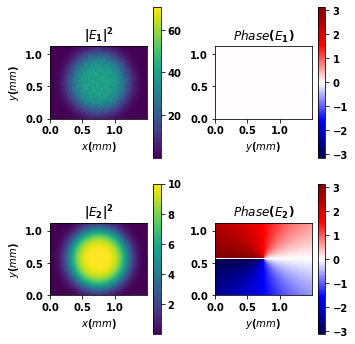

In [21]:
# Simulation Box to match experiment
pixel_pitch = 1.25e-6
magnification = 200/60
x_camera = np.arange(0,4000)*pixel_pitch  #micrometers
y_camera = np.arange(0,3000)*pixel_pitch



## Crystal
lx=x_camera[-1]/ magnification
ly=y_camera[-1]/ magnification
lz=20e-3
n_passages = 5 ###increase to see more dynamics, but in reality we have just 1

## start digital twin model
c1 = 1 #rxx / r33
c2 = 40/250 # rxx / r33
V=400
Isat = 200 #mW/cm2

SBN_sim = DigitalTwin(lx=lx,ly=ly,lz=n_passages * lz,
                      V=V,c1=c1,c2=c2,Isat=Isat,
                      alpha=0)

saveDir = 'E:\\Quarmen2d_sim\\'

SBN_sim.start_simulation_config(Nx=256,Ny=256,dz=0.05,dims=2, save_dir=saveDir,stride=25)


#######################################################################################
#############State Initialization######################################################
#######################################################################################

If1=40

factor_t = SBN_sim.factor_t

SUPER_GAUSS_EXP = 2

X, Y = SBN_sim.xx, SBN_sim.yy
X -= X.max()/2
Y -= Y.max()/2


########################################################
#################   E1    ##############################
########################################################

velocity = 0

gaussian_beam = np.zeros(np.shape(X)) + 0j

wx1 = 800e-6 * factor_t
wy1 = 800e-6 * factor_t

x_pos = -0* 200e-6 * factor_t
y_pos = 0

gaussian_beam += np.exp(-((2.0* (
                        (X - x_pos) ** 2.0 / (wx1**2.0)
                    +   (Y - y_pos) ** 2.0 / (wy1**2.0)
                        ))** SUPER_GAUSS_EXP)) + 0.00000000000000000001 + 0j

gaussian_beam*=np.exp(1j*velocity*X)

print("sound velocity ->", np.sqrt(If1/Isat), "fluid velocity ->", velocity)

gaussian_beam*=np.sqrt(If1)

A_noise=0.1
gaussian_beam = gaussian_beam*(1+whitenoise_2d_field(X,A_noise))
SBN_sim.field1.add_field_numpy(gaussian_beam)


########################################################
#################   E2    ##############################
########################################################

If2=10

v2 = 0

gaussian_beam = np.zeros(np.shape(X)) + 0j

wx1 = 800e-6 * factor_t
wy1 = 800e-6 * factor_t

x_pos = -0* 200e-6 * factor_t
y_pos = 0

gaussian_beam += np.exp(-((2.0* (
                        (X - x_pos) ** 2.0 / (wx1**2.0)
                    +   (Y - y_pos) ** 2.0 / (wy1**2.0)
                        ))** SUPER_GAUSS_EXP)) + 0.00000000000000000001 + 0j

x_pos_vortex = 0
y_pos_vortex = 0
theta = np.arctan2(Y-y_pos_vortex,X-x_pos_vortex) 
l=1
vortex_phase = np.exp(1j*l*theta)
gaussian_beam*=vortex_phase

print("sound velocity", np.sqrt(If1/Isat), velocity)

gaussian_beam*=np.sqrt(If2)
A_noise=0.0
gaussian_beam = gaussian_beam*(1+A_noise*whitenoise_2d_field(X,A_noise))


SBN_sim.field2.add_field_numpy(gaussian_beam)

SBN_sim.plot()

In [22]:
simulate = True
if simulate:
    SBN_sim.run()

Stride 0 of 116
Stride 1 of 116
Stride 2 of 116
Stride 3 of 116
Stride 4 of 116
Stride 5 of 116
Stride 6 of 116
Stride 7 of 116
Stride 8 of 116
Stride 9 of 116
Stride 10 of 116
Stride 11 of 116
Stride 12 of 116
Stride 13 of 116
Stride 14 of 116
Stride 15 of 116
Stride 16 of 116
Stride 17 of 116
Stride 18 of 116
Stride 19 of 116
Stride 20 of 116
Stride 21 of 116
Stride 22 of 116
Stride 23 of 116
Stride 24 of 116
Stride 25 of 116
Stride 26 of 116
Stride 27 of 116
Stride 28 of 116
Stride 29 of 116
Stride 30 of 116
Stride 31 of 116
Stride 32 of 116
Stride 33 of 116
Stride 34 of 116
Stride 35 of 116
Stride 36 of 116
Stride 37 of 116
Stride 38 of 116
Stride 39 of 116
Stride 40 of 116
Stride 41 of 116
Stride 42 of 116
Stride 43 of 116
Stride 44 of 116
Stride 45 of 116
Stride 46 of 116
Stride 47 of 116
Stride 48 of 116
Stride 49 of 116
Stride 50 of 116
Stride 51 of 116
Stride 52 of 116
Stride 53 of 116
Stride 54 of 116
Stride 55 of 116
Stride 56 of 116
Stride 57 of 116
Stride 58 of 116
Stride 

## 2. Analysis

## 2.1 Load Data

In [19]:
from solver.af_loader import *


sim_state = []
sim_state2 = []

zz= []
n_state=20
for passage in range(0, n_state):
    saveDir = saveDir
    print(saveDir)
    my_mesh = mesh(saveDir+"\\")
    stride_read = 1

    ntotalfiles = len([f for f in os.listdir(saveDir+"\\gnlse_field\\") if f.endswith('.af')])
    index = int(ntotalfiles * passage/n_state)-1

    print(ntotalfiles,passage/n_passages, (index+1)/ntotalfiles)
    
    
    simulation_data,zs = load_data_folder(saveDir+"\\gnlse_field\\", my_mesh,index=1,stride_read=stride_read, index_to_read = index)
    simulation_data2,zs = load_data_folder(saveDir+"\\gnlse_field2\\",my_mesh, index=2, stride_read=stride_read, index_to_read = index)
    
    sim_state.append(np.transpose(simulation_data[0]))
    sim_state2.append(np.transpose(simulation_data2[0]))
    zz.append(zs[0])

    
sim_state=np.array(sim_state)
sim_state2=np.array(sim_state2)

E:\Quarmen2d_sim\
141 0.0 0.0
E:\Quarmen2d_sim\
141 0.2 0.04964539007092199
E:\Quarmen2d_sim\
141 0.4 0.09929078014184398
E:\Quarmen2d_sim\
141 0.6 0.14893617021276595
E:\Quarmen2d_sim\
141 0.8 0.19858156028368795
E:\Quarmen2d_sim\
141 1.0 0.24822695035460993
E:\Quarmen2d_sim\
141 1.2 0.2978723404255319
E:\Quarmen2d_sim\
141 1.4 0.3475177304964539
E:\Quarmen2d_sim\
141 1.6 0.3971631205673759
E:\Quarmen2d_sim\
141 1.8 0.44680851063829785
E:\Quarmen2d_sim\
141 2.0 0.49645390070921985
E:\Quarmen2d_sim\
141 2.2 0.5460992907801419
E:\Quarmen2d_sim\
141 2.4 0.5957446808510638
E:\Quarmen2d_sim\
141 2.6 0.6453900709219859
E:\Quarmen2d_sim\
141 2.8 0.6950354609929078
E:\Quarmen2d_sim\
141 3.0 0.7446808510638298
E:\Quarmen2d_sim\
141 3.2 0.7943262411347518
E:\Quarmen2d_sim\
141 3.4 0.8439716312056738
E:\Quarmen2d_sim\
141 3.6 0.8936170212765957
E:\Quarmen2d_sim\
141 3.8 0.9432624113475178


## 2.2 Plot States

Text(0, 0.5, '$y(mm)$')

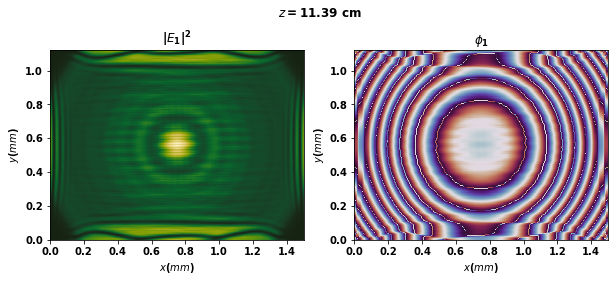

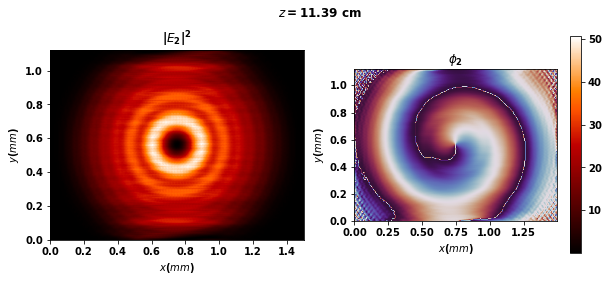

In [20]:
from solver.analysis_auxiliary_functions import *
import cmocean

index_plot = -1
z_value = zz[index_plot]/SBN_sim.factor_z*1e2
extent = [0,SBN_sim.lx*1e3,0,SBN_sim.ly*1e3]

fig,ax = plt.subplots(1,2,figsize=[10,4])

fig.suptitle(r'$z='+str(np.round(z_value,2))+'$ cm')
ax[0].set_title(r'$|E_1|^2$')
ax[0].imshow(np.abs(sim_state[index_plot])**2, aspect=SBN_sim.Nx / SBN_sim.Ny, extent = extent, origin='lower', cmap=cmocean.cm.speed_r)
ax[0].set_xlabel(r'$x(mm)$')
ax[0].set_ylabel(r'$y(mm)$')

ax[1].set_title(r'$\phi_1$')
ax[1].imshow(np.angle(sim_state[index_plot]), aspect=SBN_sim.Nx / SBN_sim.Ny, extent=extent, origin='lower', cmap=plt.cm.twilight_shifted)
ax[1].set_xlabel(r'$x(mm)$')
ax[1].set_ylabel(r'$y(mm)$')


fig,ax = plt.subplots(1,2,figsize=[10,4])

fig.suptitle(r'$z='+str(np.round(z_value,2))+'$ cm')
ax[0].set_title(r'$|E_2|^2$')
im = ax[0].imshow(np.abs(sim_state2[index_plot])**2, aspect=SBN_sim.Nx / SBN_sim.Ny, extent = extent, origin='lower', cmap=plt.cm.gist_heat)
ax[0].set_xlabel(r'$x(mm)$')
ax[0].set_ylabel(r'$y(mm)$')
plt.colorbar(im)

ax[1].set_title(r'$\phi_2$')
ax[1].imshow(np.angle(sim_state2[index_plot]), aspect=SBN_sim.Nx / SBN_sim.Ny, extent=extent, origin='lower', cmap=plt.cm.twilight_shifted)
ax[1].set_xlabel(r'$x(mm)$')
ax[1].set_ylabel(r'$y(mm)$')


## 3. Track the dynamics of the vortex center

1. Method to compute the center of the vortex
2. Compute the MSD 
3. Try to understand the Heat Bath